In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# EDA

In [24]:
data_path = "/Users/zhijunliao/Marks/DataMining/DStraining/challenge/test_restaurant.csv"
data = pd.read_csv(data_path)
data["date"] = pd.to_datetime(data['date'])

In [31]:
data.head()

,date,num_visitors
0,2000-01-01,49.128490
1,2000-01-02,50.288060
2,2000-01-03,53.549213
3,2000-01-04,45.453240
4,2000-01-05,49.469402


In [32]:
data.shape

(3651, 2)

Text(0, 0.5, 'number of visitors')

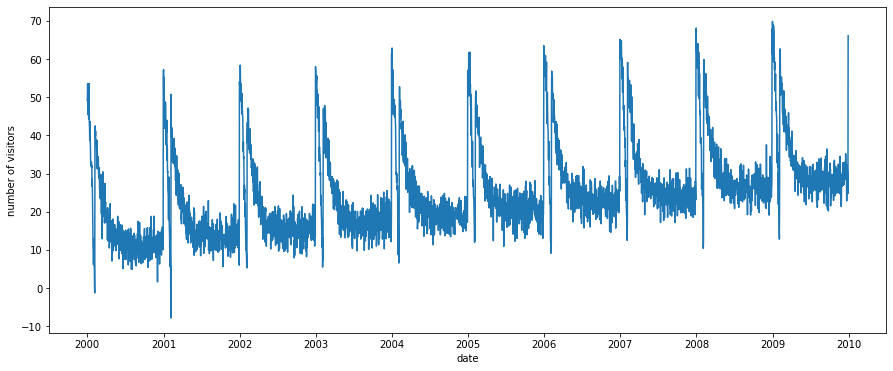

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(data['date'], data['num_visitors'])
plt.xlabel("date")
plt.ylabel("number of visitors")

# Preprocess

Since this is a one-day forward forecasting task and the data given is univariate time series data, we need to properly transform the original data into (X, y) pairs to create a training set and test set. For example, if we choose the timeframe to be 20 days, then `X` will be the number of visitors during the first 20 days and `y` will the number of visitors at the 21-st day. The time window will be 20 + 1 = 21 days. As we slide this window from earlier days to later days, we can get many (X, y) pairs and each pair would be considered as a sample/observation in our training/test set.


In [260]:
data["weekday"] = data["date"].dt.weekday
data["day"] = data["date"].dt.day
data["week"] = data["date"].dt.week

In [261]:
timeframe = 30
window_length = timeframe + 1

In [262]:
total_samples = [np.r_[data["num_visitors"].values[i:i+window_length],
                       data['weekday'][i+window_length],
                       data['day'][i+window_length],
                       data['week'][i+window_length]] 
                 for i in range(len(data) - window_length)]
total_samples = pd.DataFrame(total_samples, columns=[f"x_{i}" for i in range(timeframe)] +
                             ["y", "weekday", "day", "week"])
total_samples.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_24,x_25,x_26,x_27,x_28,x_29,y,weekday,day,week
0,49.128490,50.288060,53.549213,45.453240,49.469402,48.554940,47.056410,44.184040,45.621517,53.566944,...,28.619835,24.416117,20.280500,18.039778,11.110561,9.938544,6.099659,1.0,1.0,5.0
1,50.288060,53.549213,45.453240,49.469402,48.554940,47.056410,44.184040,45.621517,53.566944,43.316624,...,24.416117,20.280500,18.039778,11.110561,9.938544,6.099659,12.934372,2.0,2.0,5.0
2,53.549213,45.453240,49.469402,48.554940,47.056410,44.184040,45.621517,53.566944,43.316624,42.019733,...,20.280500,18.039778,11.110561,9.938544,6.099659,12.934372,8.145386,3.0,3.0,5.0
3,45.453240,49.469402,48.554940,47.056410,44.184040,45.621517,53.566944,43.316624,42.019733,38.802547,...,18.039778,11.110561,9.938544,6.099659,12.934372,8.145386,6.997644,4.0,4.0,5.0
4,49.469402,48.554940,47.056410,44.184040,45.621517,53.566944,43.316624,42.019733,38.802547,43.624550,...,11.110561,9.938544,6.099659,12.934372,8.145386,6.997644,5.816535,5.0,5.0,5.0


In [263]:
training_size = 0.8
training_data = total_samples.iloc[:int(len(total_samples) * training_size)]
test_data = total_samples.iloc[int(len(total_samples) * training_size):]

In [264]:
print(training_data.shape, test_data.shape)

(2896, 34) (724, 34)


In [265]:
training_X, training_y = training_data.drop("y", axis=1), training_data["y"]
test_X, test_y = test_data.drop("y", axis=1), test_data["y"]

# Build model

Since this is a regression task we can use **RMSE** to evaluate the performance of our model

In [266]:
xgb = XGBRegressor(n_estimators=200)
xgb.fit(training_X, training_y, )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [267]:
predictions = xgb.predict(test_X)
residuals = predictions - test_y
rmse = np.sqrt(np.power(residuals, 2).mean())
print(rmse)

4.392609025812132


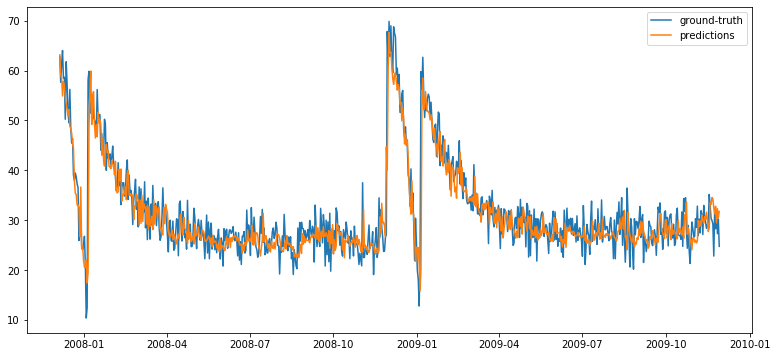

In [268]:
plt.figure(figsize=(13, 6))
plt.plot(data.iloc[test_y.index]["date"], test_y, label="ground-truth")
plt.plot(data.iloc[test_y.index]["date"], predictions, label="predictions")
plt.legend()